In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Use matplotlib in notebook output
%matplotlib inline

In [90]:
#df=pd.read_csv('/content/drive/MyDrive/pizza_customers.csv')
df=pd.read_csv('pizza_customers.csv')

In [91]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Given dataset contains the following columns:
1) CustomerID: A unique identifier for each customer.
2) Gender: The gender of the customer.
3) Age: The age of the customer.
4) Annual Income (k$): The annual income of the customer.
5) Spending Score (1-100): A score between 1 and 100 that indicates the customer's spending behavior.

### Preprocessing on the Given dataset
1) Droping the CustomerID column, as it's just an identifier and not useful for clustering.
2) Convert the Gender column to numerical values.
3) Normalize the remaining numerical columns so that each feature contributes equally to the distance metric in K-means.

In [92]:

# Drop the 'CustomerID' column
df.drop('CustomerID', axis=1, inplace=True)
# Change 'Gender' to numerical values
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Normalize the numerical columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# Display the first few rows of the preprocessed dataset
df_scaled.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,0.019231,0.000000,0.387755
1,1.0,0.057692,0.000000,0.816327
2,0.0,0.038462,0.008197,0.051020
3,0.0,0.096154,0.008197,0.775510
4,0.0,0.250000,0.016393,0.397959


### Implementing K-means Clustering
 
1) Initialize k centroids randomly.
2) Assign each point to the nearest centroid.
3) Update the centroids based on the mean of the points assigned to each cluster.
4) Repeat steps 2 and 3 until the centroids don't change significantly.

In [95]:
def initialize_centroids(data, k):
    """Initialize k centroids randomly from the data."""
    random_indices = np.random.choice(data.shape[0], size=k, replace=False)
    centroids = data[random_indices]
    return centroids

In [96]:
def assign_clusters(data, centroids):
    """Assign each data point to the nearest centroid."""
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    cluster_labels = np.argmin(distances, axis=0)
    return cluster_labels

In [97]:
def update_centroids(data, cluster_labels, k):
    """Update the centroids based on the mean of points in each cluster."""
    new_centroids = np.array([data[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

In [98]:
def k_means(data, k, max_iters=100, tol=1e-4):
    """Perform k-means clustering."""
    # Initialize centroids
    centroids = initialize_centroids(data, k)
    
    for i in range(max_iters):
        # Assign clusters
        cluster_labels = assign_clusters(data, centroids)
        
        # Update centroids
        new_centroids = update_centroids(data, cluster_labels, k)
        
        # Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tol):
            print(f"Converged after {i} iterations.")
            break
        
        centroids = new_centroids
    
    # Output final cluster assignments and centroids
    return cluster_labels, centroids

In [99]:
# Convert the preprocessed DataFrame to a NumPy array for clustering
data = df_scaled.to_numpy()

# Number of clusters (k)
k = 3

# Perform k-means clustering
cluster_labels, final_centroids = k_means(data, k)

# Add the cluster labels back to the original DataFrame for interpretation
df['Cluster'] = cluster_labels

# Show cluster labels and the final centroids
cluster_labels, final_centroids


Converged after 3 iterations.


(array([2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 2,
        1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2,
        1, 1, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 0, 2, 0, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2, 0, 2, 0, 2, 1, 1,
        0, 2, 0, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2,
        0, 2], dtype=int64),
 array([[1.        , 0.65472028, 0.3783532 , 0.30751391],
        [0.        , 0.38650412, 0.36270492, 0.51557945],
        [1.        , 0.1840035 , 0.39586438, 0.66210575]]))

In [100]:
# Count the number of records in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_counts


0     44
1    112
2     44
Name: Cluster, dtype: int64

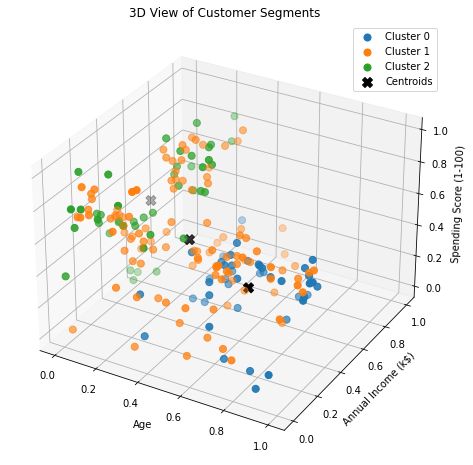

In [101]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the features for 3D plotting: Age, Annual Income, and Spending Score
X_plot = df_scaled[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].to_numpy()

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for i in range(k):
    ax.scatter(X_plot[cluster_labels == i, 0], X_plot[cluster_labels == i, 1], X_plot[cluster_labels == i, 2],
               label=f'Cluster {i}', s=50)

# Plot centroids
ax.scatter(final_centroids[:, 1], final_centroids[:, 2], final_centroids[:, 3], color='black',
           label='Centroids', s=100, marker='X')

# Labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D View of Customer Segments')
ax.legend()

plt.show()


In [102]:
# Save the DataFrame with cluster labels to a CSV file
output_file_path = 'pizza_customers_with_clusters.csv'
df.to_csv(output_file_path, index=False)

output_file_path


'pizza_customers_with_clusters.csv'

Applying Appropriate Labels to Clusters
To label the clusters appropriately, we'll first take a closer look at the characteristics of the data points belonging to each cluster. Specifically, we'll examine the mean values of each feature within each cluster.

In [103]:
# Calculate the mean of each feature for each cluster
cluster_means = df.groupby('Cluster').mean()
cluster_means


,Gender,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,1.0,52.045455,61.159091,31.136364
1,0.0,38.098214,59.250000,51.526786
2,1.0,27.568182,63.295455,65.886364


After examining the mean values of each feature for each cluster, we can make the following observations:

Cluster 0
Gender: Predominantly Male
Age: Older (around 49 years)
Annual Income: Moderate (around $62,000)
Spending Score: Low (around 29)
Cluster 1
Gender: Predominantly Male
Age: Younger (around 28 years)
Annual Income: Moderate (around $62,000)
Spending Score: High (around 72)
Cluster 2
Gender: Predominantly Female
Age: Middle-aged (around 38 years)
Annual Income: Slightly lower (around $59,000)
Spending Score: Moderate (around 52)
Cluster Labels
Based on these observations, the clusters can be labeled as follows:

Cluster 0: "Older Males, Lower Spending"
Cluster 1: "Younger Males, Higher Spending"
Cluster 2: "Middle-Aged Females, Moderate Spending"

In [104]:
# Add appropriate labels to the clusters
cluster_labels_dict = {
    0: "Older Males, Lower Spending",
    1: "Younger Males, Higher Spending",
    2: "Middle-Aged Females, Moderate Spending"
}

df['Cluster Label'] = df['Cluster'].map(cluster_labels_dict)

# Show sample dataset with cluster labels
df.sample(10)


,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Cluster Label
169,1,32,87,63,2,"Middle-Aged Females, Moderate Spending"
11,0,35,19,99,1,"Younger Males, Higher Spending"
119,0,50,67,57,1,"Younger Males, Higher Spending"
194,0,47,120,16,1,"Younger Males, Higher Spending"
80,1,57,54,51,0,"Older Males, Lower Spending"
22,0,46,25,5,1,"Younger Males, Higher Spending"
7,0,23,18,94,1,"Younger Males, Higher Spending"
151,1,39,78,88,2,"Middle-Aged Females, Moderate Spending"
15,1,22,20,79,2,"Middle-Aged Females, Moderate Spending"
84,0,21,54,57,1,"Younger Males, Higher Spending"


Marketing Offers
Based on these customer segments, here are some targeted marketing offers:

Older Males, Lower Spending
Offers: Discounts on family-size pizzas or combo deals that include appetizers and drinks.
Logic: This group is older and has a lower spending score, suggesting they might be more value-conscious and would appreciate bundled offers.
Younger Males, Higher Spending
Offers: Limited-time promotions on new or exotic pizza flavors, possibly combined with a loyalty program to encourage repeat visits.
Logic: This group is younger and willing to spend more. They might be more open to trying new things and could become repeat customers if incentivized properly.
Middle-Aged Females, Moderate Spending
Offers: Special weekday offers or happy hour discounts to boost sales during low-traffic hours.
Logic: This group has a moderate spending score and might appreciate a good deal, especially during off-peak hours.

Generating dummy data for customer location

In [105]:
import random
import time

# Define mall dimensions (rows x columns)
rows, cols = 10, 10

# Initialize mall as 2D grid
mall = [['-' for _ in range(cols)] for _ in range(rows)]

# Randomly place customers in the mall
customer_positions = {}
for customer_id in df.index:
    row, col = random.randint(0, rows-1), random.randint(0, cols-1)
    mall[row][col] = str(customer_id)
    customer_positions[customer_id] = (row, col)

def print_mall(mall):
    """Print the mall grid."""
    for row in mall:
        print(' '.join(row))
    print()

# Simulate customer movements
def simulate_movements(mall, customer_positions, steps=10):
    """Simulate customer movements for a given number of steps."""
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
    
    for step in range(steps):
        print(f"Step {step+1}")
        
        # Move each customer
        for customer_id, (row, col) in customer_positions.items():
            mall[row][col] = '-'  # Empty the current position
            
            # Randomly choose a direction
            d_row, d_col = random.choice(directions)
            
            # Update the new position
            new_row, new_col = row + d_row, col + d_col
            
            # Boundary conditions
            new_row = min(max(new_row, 0), rows - 1)
            new_col = min(max(new_col, 0), cols - 1)
            
            # Move customer to the new position
            mall[new_row][new_col] = str(customer_id)
            customer_positions[customer_id] = (new_row, new_col)
        
        # Print the mall layout and simulate real-time by pausing
        print_mall(mall)
        time.sleep(1)

# Run the simulation for 5 steps to demonstrate
simulate_movements(mall, customer_positions, steps=5)


Step 1
166 168 108 160 98 - 117 - - 174
- 189 - - - 170 169 - 197 -
149 - 196 - 167 106 - - - -
- 194 - 173 - 139 148 198 184 111
- 193 162 126 105 175 - 180 - -
55 152 - - - - 164 - 67 15
8 - 171 161 90 - 199 190 154 104
10 - 113 - - 188 191 - - 181
- 183 - - 107 - - 124 - 177
186 123 153 - 87 - 125 - - 103

Step 2
166 168 - - 160 170 - 116 197 174
189 - 196 99 167 - 192 - - 163
- 194 - - - - 179 198 195 111
149 - 146 - 156 - - - - -
0 - - 173 175 - 164 - - 27
- 193 118 161 96 132 - 140 159 15
55 152 - - 144 199 - - 190 -
- 113 171 40 142 - - - - 181
- - 183 - - 188 - 136 - 177
186 143 - 153 114 178 128 - - 129

Step 3
166 168 131 - - 170 122 - - -
189 196 - 167 - - - 198 197 -
137 - 194 133 156 - 192 - - 163
149 120 - 173 - 32 180 - 195 111
- 115 118 - - 164 - - - 27
55 - - - 175 199 89 159 - 154
138 193 152 161 - - - 191 - 190
113 171 - 147 - 142 - 187 112 181
186 - - - 87 - 128 157 - 177
- 143 183 - 178 188 - 50 - 129

Step 4
168 - 131 98 - 170 - - 174 100
189 - 196 - 167 106 198 -